## Notebook to compute observational (search) upper limits on the local merger 
#### We study four different models
* BNS systems in isolated formation scenario: Belczynski et al. (2018a) 
* NSBH systems in globular clusters: Arca Sedda (2020b) 
* NSBH systems in hierarchical triples: Trani et al. (2021) 
* NSBH systems in nuclear clusters: Fragione et al. (2019) 

#### The script estimates the search sensitive $\langle VT \rangle$ for each model using Monte Carlo integration scheme.   

In [193]:
import pycbc
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
from pycbc import conversions
from scipy.stats import loguniform, gaussian_kde
from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator, LinearNDInterpolator
from scipy.integrate import trapz, cumtrapz, quad
from random import choices
from collections import Counter
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from decimal import Decimal
from astropy import cosmology
from pycbc import cosmology as pycbccosmology
import subprocess
import astropy
from pycbc.population.population_models import *
from tqdm import tqdm
import glob
from lal import YRJUL_SI as lal_YRJUL_SI
from matplotlib.path import Path


sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

mpl.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams['figure.dpi'] = 600
mpl.rcParams['font.size'] = 18

rc('font', family='serif', weight = 'bold')
rc('text', usetex=True)

colors = sns.color_palette("husl", 8)

np.random.seed(123)

In [318]:
def read_injections(files, BNS, pop_det_mchirp_samples):
    """
    Reads injection data from the given set of files and extracts relevant parameters.

    Parameters:
    ----------
    files : list of str
        List of paths to the HDF5 files containing injection data.
    
    BNS : bool
        If True, the Binary Neutron Star (BNS) injections are considered. The function will then adjust
        the chirp mass (`mchirp`) distribution based on `pop_det_mchirp_samples`. If False, it will use 
        a uniform distribution between 1.0 and the maximum value in `pop_det_mchirp_samples`.
    
    pop_det_mchirp_samples : list or array-like
        Chirp mass samples which are used to either randomly choose a chirp mass (when BNS=True) 
        or to set the maximum value for the uniform distribution (when BNS=False).

    Returns:
    -------
    missed : dict
        Dictionary containing parameters for missed injections. Keys are:
        - 'dist': distances
        - 'mchirp': chirp masses
        - 'eccentricity': eccentricities
        - 'redshift': redshifts
    
    found : dict
        Dictionary containing parameters for found injections. Keys are:
        - 'dist': distances
        - 'mchirp': chirp masses
        - 'eccentricity': eccentricities
        - 'sig_exc': significance excess values
        - 'redshift': redshifts
    
    t : list
        List of foreground times extracted from the HDF5 files' attributes, normalized to years.

    fvalues : list
        List of significance excess values associated with the found injections.
    """
    t = []
    for fi in files:
        with h5py.File(fi, 'r') as f:
            temp_foundi = f['found_after_vetoes/injection_index'][:]
            temp_missedi = f['missed/after_vetoes'][:]
            
            mchirp_found = conversions.mchirp_from_mass1_mass2(f['injections/mass1'][:][temp_foundi], f['injections/mass2'][:][temp_foundi])
            mchirp_missed = conversions.mchirp_from_mass1_mass2(f['injections/mass1'][:][temp_missedi], f['injections/mass2'][:][temp_missedi])
            ecc_found = f['injections/eccentricity'][:][temp_foundi]
            ecc_missed = f['injections/eccentricity'][:][temp_missedi]
            
            #sub_pop_found_ind = np.logical_and(mchirp_found <= 4.35 , ecc_found >= ecc_cut)

            #sub_pop_found_ind = np.where(np.abs(mchirp_found - 1.21877079 <= 0.01))[0]
            #foundi = temp_foundi[np.where(np.abs(mchirp_found - 1.21877079 <= 0.01))[0]]
            #missedi = temp_missedi[np.where(np.abs(mchirp_missed - 1.21877079 <= 0.01))[0]]
            #sig_exc = f['found_after_vetoes/ifar_exc'][:][sub_pop_found_ind]
            
            foundi = temp_foundi
            missedi = temp_missedi
            sig_exc = f['found_after_vetoes/ifar_exc'][:]

            if bool(BNS):
                m1, m2 = f['injections/mass1'][:], f['injections/mass2'][:]
                old_mchirp = pycbc.pnutils.mass1_mass2_to_mchirp_eta(m1, m2)[0]
                mchirp = np.random.choice(pop_det_mchirp_samples, len(old_mchirp))
                
                old_dist = f['injections/distance'][:]
                dist = old_dist * (mchirp/old_mchirp)**(5.0/6)
        
                eccentricity = f['injections/eccentricity'][:]
                redshift = pycbccosmology.redshift(f['injections/distance'][:])
                
            else:
                m1, m2 = f['injections/mass1'][:], f['injections/mass2'][:]
                old_mchirp = pycbc.pnutils.mass1_mass2_to_mchirp_eta(m1, m2)[0]
                mchirp = np.random.uniform(1.0, max(pop_det_mchirp_samples), len(old_mchirp))
                
                old_dist = f['injections/distance'][:]
                dist = old_dist * (mchirp/old_mchirp)**(5.0/6)
        
                eccentricity = f['injections/eccentricity'][:]
                redshift = pycbccosmology.redshift(f['injections/distance'][:])

            # Add the current values to the arrays
            missed['dist']  = np.append(missed['dist'], dist[missedi])
            missed['mchirp']= np.append(missed['mchirp'], mchirp[missedi])
            missed['eccentricity']= np.append(missed['eccentricity'], eccentricity[missedi])
            missed['redshift'] = np.append(missed['redshift'], redshift[missedi])
            
            found['dist']   = np.append(found['dist'], dist[foundi])
            found['mchirp'] = np.append(found['mchirp'], mchirp[foundi])
            found['eccentricity'] = np.append(found['eccentricity'], eccentricity[foundi])
            found['sig_exc'] = np.append(found['sig_exc'], sig_exc)
            found['redshift'] = np.append(found['redshift'], redshift[foundi])            
            t.append(f.attrs['foreground_time_exc'] / lal_YRJUL_SI)
        
    print('Total found:', len(found['mchirp']), 'missed: ', len(missed['mchirp']), 'injections: ', len(found['mchirp']) + len(missed['mchirp']) )
    fvalues = found['sig_exc']

    return missed, found, t, fvalues

### Obtain $\mathcal{M}_c$ and $e_{10}$ distributions from 4 different astrophysical models

In [317]:
model = 'trani'

if model == 'belzynscki':
    model_label  = 'Belczynski et al. (2018a) (isolated binary)'
    ecc_10_file  = 'pop-models/bns/belzynscki/ecc_10.hdf'
    mchirp_file = 'pop-models/bns/belzynscki/mchirp.hdf'
    BNS = True
    
    
elif model == 'sedda':
    model_label = 'Arca Sedda (2020b) (globular cluster)'
    ecc_10_file = 'pop-models/nsbh/sedda/ecc_10.hdf'
    mchirp_file = 'pop-models/nsbh/sedda/mchirp.hdf' 
    BNS = False
   
elif model == 'trani':
    model_label = 'Trani et al. (2021) (triples)'
    ecc_10_file = 'pop-models/nsbh/trani/ecc_10.hdf'
    mchirp_file = 'pop-models/nsbh/trani/mchirp.hdf'
    BNS = False

elif model == 'fragione':
    model_label = 'Fragione et al. (2019) (nuclear cluster)'
    ecc_10_file = 'pop-models/nsbh/fragione/ecc_10.hdf'
    mchirp_file = 'pop-models/nsbh/fragione/mchirp.hdf'
    BNS = False
    
elif model == 'redshifted-belzynscki':
    ecc_10_file  = 'pop-models/bns/belzynscki/ecc_10.hdf'
    
else:
    raise ValueError("Check model name")
    
print("\n \t \t \t Computing for %s \n " %model)


 	 	 	 Computing for trani 
 


### Get $e_{10}$ samples and PDF (target ecc distribution)
#### elow is the threshold for the eccentricity: only systems having $e_{10}$ above this value would be counted. 

In [306]:
def read_ecc_samples(samples_file):
    ''' This functions extracts eccentricity samples, a grid of eccentricity values and the corresponding pdf values at the grid points 
    from a given .hdf file 
    
     Parameters:
    ----------
    samples_file : str
        Path to the HDF5 file containing sample data.

    Returns:
    -------
    ecc_grid : numpy array
        Array of eccentricity grid values extracted from the HDF5 file.
    
    pdf_values : numpy array
        Array of probability density function (PDF) values associated with the samples.
    
    samples : numpy array
        Array of sample values extracted from the HDF5 file.
    '''
    
    f = h5py.File(samples_file, 'r')    
    ecc_grid = f['ecc_grid'][:]
    pdf_values = f['pdf_values'][:]
    samples = f['samples'][:]
    f.close()
    return ecc_grid, pdf_values, samples

ecc_grid, pdf_values, ecc_samples = read_ecc_samples(ecc_10_file)
loge_samples = np.log10(ecc_samples)
ecc_spacing = ecc_grid[1] - ecc_grid[0]

ecc_spacing = 0.1
loge_grid = np.arange(min(loge_samples), max(loge_samples), ecc_spacing)

#values, bins = np.histogram(loge_samples, density=True, bins=50)
#pdf_target_ecc_interp = interp1d(10**bins[:-1], values, fill_value=0.0, kind='linear')
#pdf_target_ecc_interp = interp1d(ecc_grid, pdf_values, fill_value='extrapolate', kind='linear')

pdf_target_ecc_interp = gaussian_kde(ecc_samples)
pdf_target_logecc_interp = gaussian_kde(loge_samples)

# We can estimate the fraction of sources with detectable eccentricities e.g. 0.01
## Define a new grid with the exact spacing as the original grid but starting at a higher value e.g e in [0.01, 1]
elow = 1e-9
ehigh = max(ecc_samples)
newecc_grid = np.arange(elow, max(ecc_grid), ecc_spacing)
newloge_grid = np.arange(np.log10(elow), max(loge_samples), ecc_spacing)

# Estimating the number of sources (in \%) in our region of interest 
full_ecc =    np.trapz(pdf_target_logecc_interp(loge_grid) , loge_grid)
partial_ecc = np.trapz(pdf_target_logecc_interp(newloge_grid) , newloge_grid)

print('Sources in the log(ecc) ranging from ', [round(min(loge_grid),3), round(max(loge_grid),3)], ': ', full_ecc)
print('Sources in the log(ecc) ranging from ', [round(min(newloge_grid),3), round(max(newloge_grid),3)], ': ', partial_ecc)
print('Fraction of sources', round(partial_ecc/full_ecc*100,3), '% and check', \
      len(np.where(ecc_samples>elow)[0]), 'out of', len(ecc_samples), '=', len(np.where(ecc_samples >= elow)[0])/len(ecc_samples)*100, '%')
print('Ecc cut (max ecc in the population): ', ehigh)

Sources in the log(ecc) ranging from  [-3.848, -0.448] :  0.9983924320017056
Sources in the log(ecc) ranging from  [-9.0, -0.5] :  0.9988568522351159
Fraction of sources 100.047 % and check 24999 out of 24999 = 100.0 %
Ecc cut (max ecc in the population):  0.35974933516370655


### Get $\mathcal{M}_c$ samples and PDF (target mchirp distribution)

In [307]:
def read_mchirp_samples(samples_file):
    ''' This functions extracts mchirp samples, a grid of mchirp values and the corresponding pdf values at the grid points 
    from a given .hdf file '''
    f = h5py.File(samples_file, 'r')
    mchirp_grid = f['mchirp_grid'][:]   
    samples = f['samples'][:]
    pop_redshift = f['redshift'][:]
    return mchirp_grid, samples, pop_redshift

mchirp_grid, mchirp_samples, pop_redshift = read_mchirp_samples(mchirp_file)
mchirp_samples = mchirp_samples[:len(ecc_samples)]
pop_redshift = pop_redshift[:len(ecc_samples)]
pop_det_mchirp_samples = mchirp_samples * (1 + pop_redshift)

mchirp_spacing = mchirp_grid[1] - mchirp_grid[0]
pdf_target_src_mc_interp = gaussian_kde(mchirp_samples)
pdf_target_det_mc_interp = gaussian_kde(pop_det_mchirp_samples)
pdf_target_z_interp = gaussian_kde(pop_redshift)


target_dist_samples = pycbccosmology.cosmological_quantity_from_redshift(pop_redshift, 'luminosity_distance')
target_chirp_dist_samples = conversions.chirp_distance(target_dist_samples, pop_det_mchirp_samples)
pdf_target_dist_interp = gaussian_kde(target_dist_samples)
pdf_target_chirp_dist_interp = gaussian_kde(target_chirp_dist_samples)

## Setting the lower limit (mc_min) according the model 
mc_low = min(pop_det_mchirp_samples)
mc_high = max(pop_det_mchirp_samples)
    
newmchirp_grid = np.arange(mc_low, max(mchirp_grid), mchirp_spacing)

# Estimating the number of sources (in \%) in our region of interest 
full_mchirp = np.trapz(pdf_target_src_mc_interp(mchirp_grid), mchirp_grid)
partial_mchirp = np.trapz(pdf_target_src_mc_interp(newmchirp_grid), newmchirp_grid)

print('Sources in the mchirp ranging from: ', [round(min(mchirp_grid),2), round(max(mchirp_grid),2)], full_mchirp)
print('Sources in the mchirp ranging from: ', [round(min(newmchirp_grid),2), round(max(newmchirp_grid),2)], partial_mchirp)
print('Mchirp fraction: ',  partial_mchirp/full_mchirp*100, '%')

print('Total fraction of sources:', round(partial_mchirp*partial_ecc/full_mchirp/full_ecc, 6))

Sources in the mchirp ranging from:  [1.13, 9.67] 0.999920850259876
Sources in the mchirp ranging from:  [1.43, 9.66] 0.9994553219655224
Mchirp fraction:  99.95344348562864 %
Total fraction of sources: 0.999999


### Read injection results from the search

In [308]:
missed = {
    'dist'  : np.array([]),
    'mchirp': np.array([]),
    'eccentricity': np.array([]),
    'redshift': np.array([])
}
found = {
    'dist'  : np.array([]),
    'mchirp': np.array([]),
    'eccentricity': np.array([]),
    'sig_exc' : np.array([]),
    'redshift': np.array([])
}

inj_files = glob.glob('inj_results/*.hdf')

ecc_cut = 0.00
print('Using ecc_cut: ', ecc_cut)
missed, found, t, fvalues = read_injections(inj_files, BNS, pop_det_mchirp_samples)
og_inj_dist = np.concatenate((missed['dist'], found['dist']))
pdf_og_inj_dist = gaussian_kde(og_inj_dist)

obs_time = 0.682
print('Total obs time: ', obs_time)

Using ecc_cut:  0.0
Total found: 17128 missed:  88253 injections:  105381
Total obs time:  0.682


### Remap injection distributions

In [309]:
def remap_ecc(found, missed, ehigh, BNS):
    print('Remaping eccentricities')
    if bool(BNS):
        temp_found = np.random.choice(ecc_samples, len(found['eccentricity']))
        temp_missed = np.random.choice(ecc_samples, len(missed['eccentricity']))
        found['eccentricity'] = temp_found
        missed['eccentricity'] = temp_missed        
    else:
        #temp_found = 10**(np.random.uniform(-9, np.log10(0.48), len(found['eccentricity'])))
        temp_found = 10**(np.random.uniform(-9, np.log10(ehigh), len(found['eccentricity'])))

        temp_missed = 10**(np.random.uniform(-9, np.log10(ehigh), len(missed['eccentricity'])))
        found['eccentricity'] = temp_found
        missed['eccentricity'] = temp_missed
        
def remap_mchirp_and_distance(found, missed, mc_low, mc_high):
    print('Remaping mchirp and dist')
    #temp_mc_array = np.random.uniform(mc_low, 3.13, 100)
    #temp_found_mchirp = np.random.choice(temp_mc_array, len(found['mchirp']))
    #temp_missed_mchirp = np.random.choice(temp_mc_array, len(missed['mchirp']))
    
    temp_found_mchirp = np.random.uniform(1.0, 4.35, len(found['mchirp']))
    temp_missed_mchirp = np.random.uniform(1.0, 4.35, len(missed['mchirp']))
    
    #temp_found_mchirp = np.random.choice(pop_det_mchirp_samples, len(found['mchirp']))
    #temp_missed_mchirp = np.random.choice(pop_det_mchirp_samples, len(missed['mchirp']))
    
    temp_found_dist = found['dist'] * (temp_found_mchirp / found['mchirp'])**(5.0/6)
    temp_missed_dist = missed['dist'] * (temp_missed_mchirp / missed['mchirp'])**(5.0/6)
    
    found['mchirp'] = temp_found_mchirp
    missed['mchirp'] = temp_missed_mchirp
    
    found['dist'] = temp_found_dist
    missed['dist'] = temp_missed_dist

### Impose population constraints and IFAR threshold of >= 100

In [310]:
#remap eccentricities
print(len(found['dist']), 'max found dist: ', max(found['dist']))
remap_ecc(found, missed, ehigh, BNS)

print('Inj outside TB after remapping: ', len(np.where(found['dist'] > 1100)[0]))

m_dist = missed['dist']
binfsig = fvalues

ifar_cond = binfsig >= 100.0
dist_cond = found['dist'] < 1100
mchirp_cond = np.logical_and(found['mchirp'] < 4.35, found['mchirp'] > 1.0)

loud = ifar_cond & dist_cond & mchirp_cond
quiet = ~loud

#loud = np.logical_and(binfsig >= 100.0, found['dist'] < 1100, found['mchirp'] < 4.35)
#quiet = np.logical_or(binfsig < 100.0, found['dist'] > 1100, found['mchirp'] > 4.35)

f_dist = found['dist'][loud]
fm_dist = found['dist'][quiet]
m_dist_full = np.concatenate((m_dist, fm_dist))
all_dist = np.concatenate((found['dist'], missed['dist']))


found_mchirp = found['mchirp'][loud]
found_ecc = found['eccentricity'][loud]
missed_mchirp = np.concatenate((missed['mchirp'], found['mchirp'][quiet]))
missed_ecc = np.concatenate((missed['eccentricity'], found['eccentricity'][quiet]))
all_mchirp = np.concatenate((found_mchirp, missed_mchirp))
all_ecc = np.concatenate((found_ecc, missed_ecc))

z_found = np.array(pycbccosmology.redshift(f_dist))
z_missed = np.array(pycbccosmology.redshift(m_dist_full))
z_full = np.concatenate((z_found, z_missed))

src_found_mchirp = found_mchirp/(1 + z_found)
src_missed_mchirp = missed_mchirp/(1 + z_missed) 
all_src_mchirp = np.concatenate((src_found_mchirp, src_missed_mchirp))

max_dist = max(f_dist.max(), m_dist_full.max())
max_mc = max(found['mchirp'])
max_z = max(pycbccosmology.redshift(f_dist))

print('Max dist: ', max_dist, 'Found mc range: ', min(found['mchirp']), max_mc, 'max redshift: ', max_z)
print('After IFAR cutoff')
print('found: ', len(found['dist']), '---->', len(f_dist))
print('missed ', len(missed['dist']), '---->', len(m_dist_full))
print('found/missed: ', len(f_dist)/len(m_dist_full))
#print('Lengths \t: ', len(f_dist), len(m_dist_full), len(found_mchirp), len(missed_mchirp))\

17128 max found dist:  2942.9640217475944
Remaping eccentricities
Inj outside TB after remapping:  775
Max dist:  3154.346828492527 Found mc range:  1.0000203271820771 11.149385436607448 max redshift:  0.17339704603253153
After IFAR cutoff
found:  17128 ----> 4148
missed  88253 ----> 101233
found/missed:  0.0409747809508757


### Obtain PDFs of injected parameters  

In [319]:
mchirp_inj_samples = np.random.uniform(1.0, 4.35, 100000)
mchirp_inj_grid = np.linspace(1.0, 4.35, 10000)
pdf_inj_mc_interp = gaussian_kde(all_mchirp)

ecc_inj_samples = np.random.uniform(0, 1, 100000)
ecc_inj_grid = np.linspace(0, 1, 1000)
pdf_inj_ecc_interp = gaussian_kde(all_ecc)

chirpdist_samples = np.random.uniform(40, 500, 100000)
chirp_dist_grid = np.linspace(40, 500, 1000)
dist_inj_samples = conversions.distance_from_chirp_distance_mchirp(chirpdist_samples, mchirp_inj_samples)

pdf_inj_chirp_dist_interp = interp1d(chirp_dist_grid, np.ones(len(chirp_dist_grid)), fill_value='extrapolate')
pdf_inj_z_interp = gaussian_kde(z_full)

pdf_inj_dist_interp = gaussian_kde(all_dist)

### Plot the target and injected PDFs

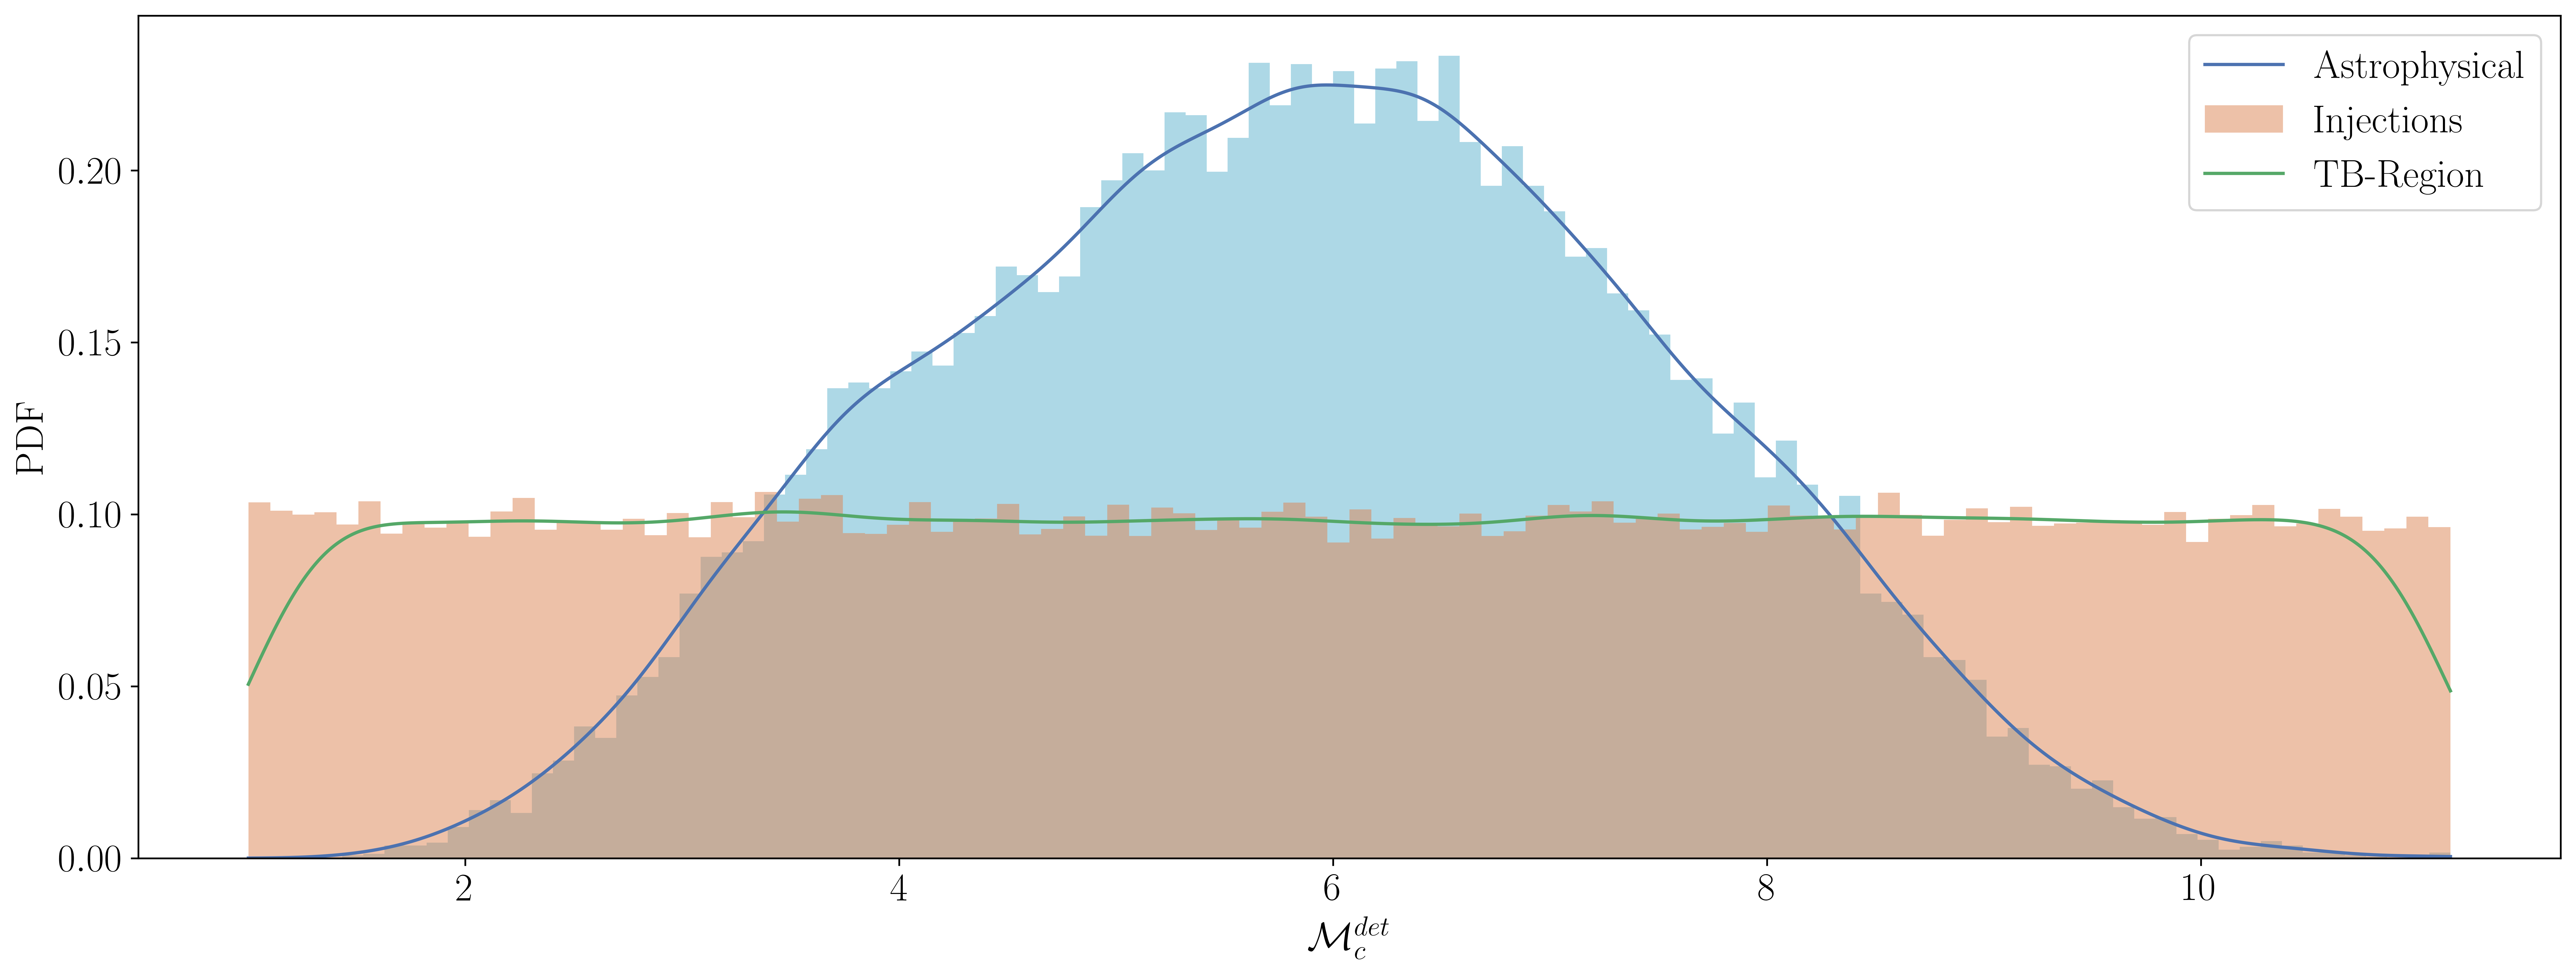

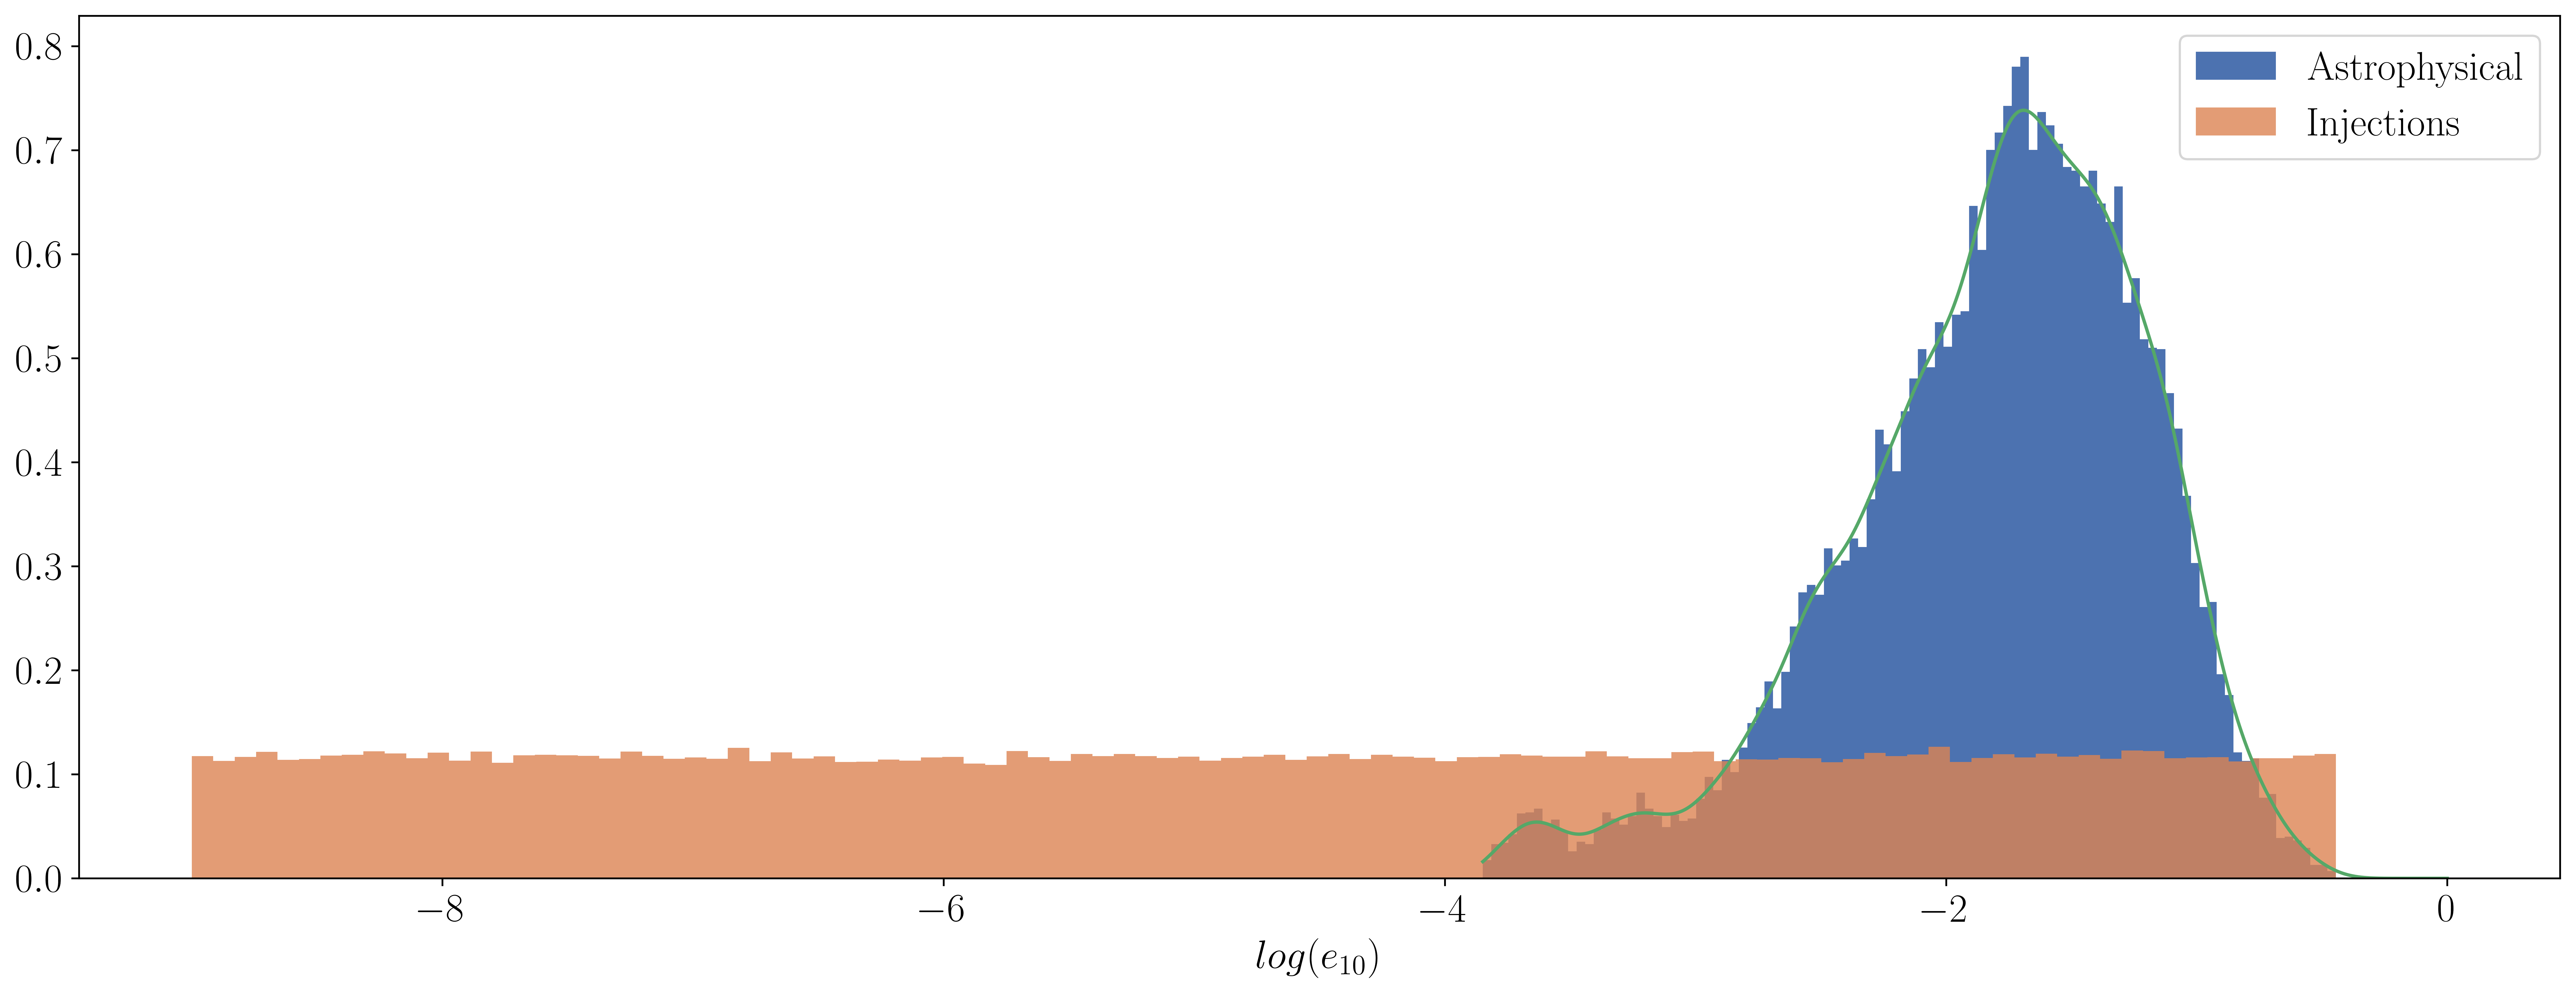

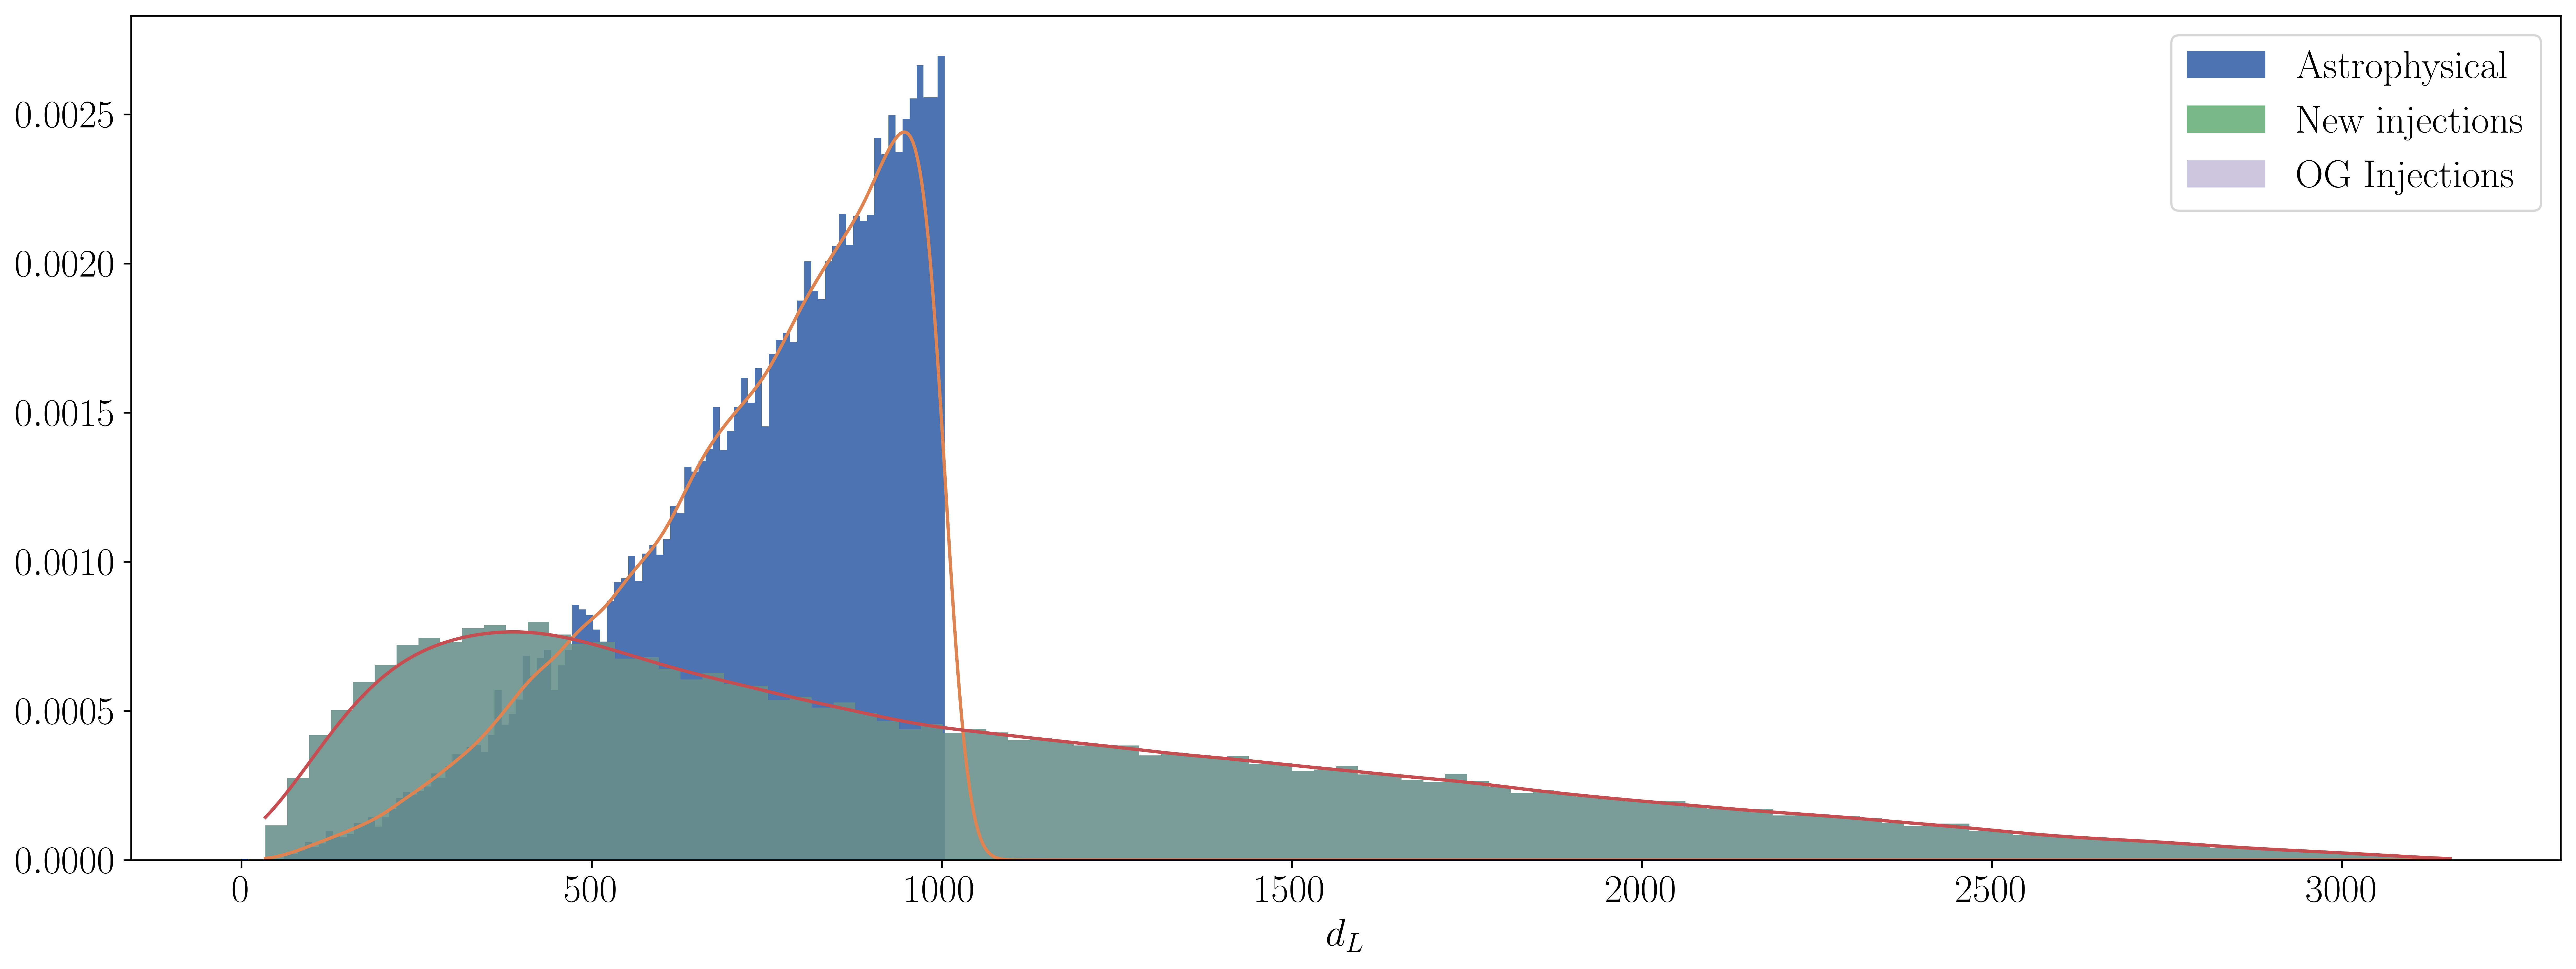

In [314]:
## Mchirp
mc = np.linspace(1.0, max(pop_det_mchirp_samples), 1000)
plt.plot(mc, pdf_target_det_mc_interp(mc),label='Astrophysical')
plt.hist(pop_det_mchirp_samples, bins=100, density=True, color='lightblue')
mc_inj = np.linspace(1.0, max(all_mchirp), 1000)
plt.hist(all_mchirp, density=True, bins=100, alpha=0.5, label='Injections')
plt.plot(mc_inj, pdf_inj_mc_interp(mc_inj), label='TB-Region')


plt.xlabel("$\mathcal{M}_{c}^{det}$")
plt.ylabel('PDF')
plt.legend()
plt.show()

## Eccentricity
e = np.linspace(0, 1, 1000)
temploge = np.linspace(min(loge_samples), 0, 1000)
plt.hist(loge_samples, density = True, bins=100, label='Astrophysical')
plt.hist(np.log10(np.concatenate((found_ecc, missed_ecc))), density=True, bins=100, label='Injections', alpha=0.8)
plt.plot(temploge, pdf_target_logecc_interp(temploge))
plt.xlabel('$log(e_{10})$')
plt.legend()
plt.show()


## Distance
x = np.linspace(min(all_dist), max(all_dist), 1000)
plt.hist(target_dist_samples, bins=100, density=True, label='Astrophysical')
plt.plot(x, pdf_target_dist_interp(x))

plt.hist(all_dist, density=True, bins=100, label='New injections', alpha=0.8)
plt.plot(x, pdf_inj_dist_interp(x))
plt.hist(og_inj_dist, bins=100, density=True, label='OG Injections', alpha=0.4)

plt.xlabel('$d_{L}$')
plt.legend()
plt.show()

### Compute the weights

In [315]:
print('Computing for model: ', model)

found_weights = pdf_target_det_mc_interp(found_mchirp) * pdf_target_dist_interp(f_dist) * pdf_target_ecc_interp(found_ecc) \
                        / pdf_inj_mc_interp(found_mchirp)  / pdf_inj_dist_interp(f_dist) / pdf_inj_ecc_interp(found_ecc) 
missed_weights = pdf_target_det_mc_interp(missed_mchirp) * pdf_target_dist_interp(m_dist_full) *  pdf_target_ecc_interp(missed_ecc) \
                        / pdf_inj_mc_interp(missed_mchirp)  / pdf_inj_dist_interp(m_dist_full) / pdf_inj_ecc_interp(missed_ecc)


all_weights = np.concatenate((found_weights, missed_weights))
all_z = np.concatenate((z_found, z_missed))
mc_weight_samples = np.concatenate((found_weights, 0 * missed_weights))
mc_sum = sum(mc_weight_samples)

mc_norm = sum(all_weights)
print(mc_norm, mc_sum)

Computing for model:  trani
99330.50390156434 757.688110064924


In [322]:
print('Model: ', model) 
ntotal = 2941176 
ndetections = ntotal * mc_sum / sum(all_weights) 
rate = 2.303 * 675000 / ndetections / 0.68

print('Upper limit: ', rate , 'GPc^{-3} Yr^{-1}', '\n', 'ndetections: ', ndetections, 
      'mc_sum/mc_norm: ', mc_sum/mc_norm, 'mc_sum: ', mc_sum, 'mc_norm: ', mc_norm)

Model:  trani
Upper limit:  101.89666053373361 GPc^{-3} Yr^{-1} 
 ndetections:  22435.1432568663 mc_sum/mc_norm:  0.007627949927806531 mc_sum:  757.688110064924 mc_norm:  99330.50390156434
